<a href="https://www.kaggle.com/code/adityakumarsingh135/damage-prediction-24?scriptVersionId=255935254" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = pd.read_csv('/kaggle/input/damage-prediction/train_values.csv')
train_label = pd.read_csv('/kaggle/input/damage-prediction/train_labels.csv')
test = pd.read_csv('/kaggle/input/damage-prediction/test_values.csv')

In [3]:
from matplotlib import pyplot as plt 
import seaborn as sns 
import scipy

In [4]:
res = train_label.building_id.equals(train.building_id)

In [5]:
train['damage_grade'] = train_label.damage_grade

In [6]:
train.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
count,2.606010e+05,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,5.256755e+05,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,...,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119,2.238272
std,3.045450e+05,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,...,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364,0.611814
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.611900e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,5.257570e+05,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,7.897620e+05,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [7]:
train.dtypes.value_counts()

int64     32
object     8
Name: count, dtype: int64

In [8]:
print('objective data types:\n')
def get_ob(train, p = False):
    obj_types = []
    for column in train.columns:
        if train[column].dtype == 'object':
            if p: print(column)
            obj_types.append(column)
    return obj_types
obj_types = get_ob(train, True)

objective data types:

land_surface_condition
foundation_type
roof_type
ground_floor_type
other_floor_type
position
plan_configuration
legal_ownership_status


In [9]:
# transform everything into int for edxamplr kuch datset me t, r, s, a, c ye sab diya to 
# unki int form me convert karne ke liye function
def transform_to_int(train, obj_types):
    #assign dictonaries for every column and replacement 
    d_lsc = {'n':0, 'o':1, 't':2}
    d_ft = {'h':0, 'i':1, 'r':2, 'u':3, 'w':4}
    d_rt = {'n':0, 'q':1, 'x':2}
    d_gft = {'f':0, 'm':1, 'v':2, 'x':3, 'z':4}
    d_oft = {'j':0, 'q':1, 's':2, 'x':3}
    d_pos = {'j':0, 'o':1, 's':2, 't':3}
    d_pc = {'a':0, 'c':1, 'd':2, 'f':3, 'm':4, 'n':5, 'o':6, 'q':7, 's':8, 'u':9}
    d_los = {'a':0, 'r':1, 'v':2, 'w':3}

    replacements = [d_lsc, d_ft, d_rt, d_gft, d_oft, d_pos, d_pc, d_los]
    # replace using lambdda series.map(lambda)
    for i,col in enumerate(obj_types):
        train[col] = train[col].map(lambda a:replacements[i][a]).astype('int64')
transform_to_int(train, obj_types)

In [10]:
train.drop('building_id', inplace = True, axis = 1)

In [11]:
train.dtypes.value_counts()

int64    39
Name: count, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier 

In [13]:
y = train.pop('damage_grade')
x = train.copy()

In [14]:
x.shape

(260601, 38)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y,)

In [16]:
rcf = RandomForestClassifier()
model = rcf.fit(x_train, y_train)

model.score(x_test, y_test)

0.7171647403723658

In [17]:
y_pred = model.predict(x_test)

In [18]:
f1_score(y_test, y_pred, average='micro')

0.7171647403723658

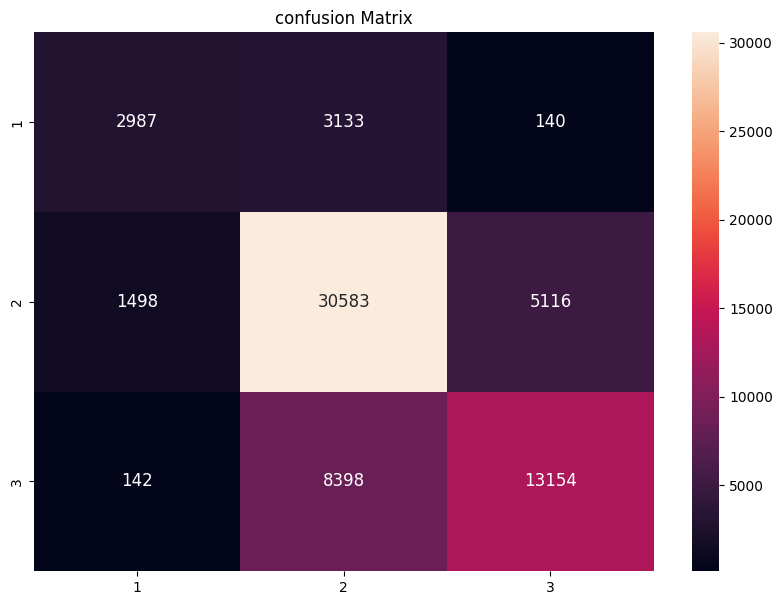

In [19]:
# now get the confusion matrix 
def get_conf_matrix(y_test, y_pred):
    data = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))

    cm.index_name = 'Observed'
    cm.columns_name = 'Predicted'
    plt.figure(figsize = (10, 7))
    sns.heatmap(cm, annot= True, fmt="d", annot_kws={"size": 12})
    plt.title("confusion Matrix")
    plt.show()

get_conf_matrix(y_test, y_pred)

In [20]:
importance = pd.DataFrame({"Feature":list(x), "Importance": rcf.feature_importances_}) # build a dataframe with features and their importance
importance = importance.sort_values(by="Importance", ascending=False) #sort by importance
importance

,Feature,Importance
2,geo_level_3_id,0.155005
0,geo_level_1_id,0.138622
1,geo_level_2_id,0.135740
4,age,0.122323
5,area_percentage,0.110682
6,height_percentage,0.056030
26,count_families,0.025123
8,foundation_type,0.024065
9,roof_type,0.023837
12,position,0.021982


the geographic location has the highest impact as we can see 

In [21]:
# importing the models 
import sklearn 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [22]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
]

def model_test(X, y, classifiers):
    x_train, x_test, y_train, y_test = train_test_split(x , y , test_size = 0.1,
                                                       random_state = 42)
    for model in classifiers :
        this_model = model.__class__.__name__ # get the name of the classifier
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        print(f'{this_model} f1 score')
        score = f1_score(y_test, y_pred, average='micro')


        print(f'{score:.4f}')
        print('\n')

In [23]:
model_test(x, y, classifiers)

DecisionTreeClassifier f1 score
0.6558


RandomForestClassifier f1 score
0.7227


AdaBoostClassifier f1 score
0.6451


GradientBoostingClassifier f1 score
0.6823




if you see the random forest classifier perform the best 

In [24]:
import xgboost as xgb

In [25]:
def get_original():
    df = pd.read_csv('/kaggle/input/damage-prediction/train_values.csv')
    df.drop('building_id', axis = 1, inplace =True)
    obj_types = get_ob(df)
    transform_to_int(df, obj_types)
    df['damage_grade'] = train_label.damage_grade

    return df 

df = get_original()

#a function jo help karega dataframe ko x and y me split karne me 
def get_xy(df):
    y = df.pop('damage_grade')
    x = df
    return x, y

In [26]:
y = df.damage_grade
x = df.drop('damage_grade', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, 
                                                   random_state = 42)

In [27]:
x.shape

(260601, 38)

In [28]:
pd.value_counts(y_test)

/tmp/ipykernel_19/1894360198.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_test)


damage_grade
2    14793
3     8722
1     2546
Name: count, dtype: int64

In [29]:
xgbc = xgb.XGBClassifier()

In [30]:
x, y = get_xy(df)

In [31]:
# function for removing outlier z_score
def remove_outliers(df, col_cutoff = 0.01, z_score = 3.5): #define a function to get rid of all outliers of the most important columns
    important_cols = importance[importance.Importance>col_cutoff]['Feature'].tolist() #get all columns with importance > 0.01.  
    important_cols = [col for col in important_cols if col in df.columns]
    df_new = df.copy() #init the new df
    for col in important_cols: 
        df_new = df_new[np.abs(scipy.stats.zscore(df_new[col]))<z_score] #removing all rows where a z-score is >3
    return df_new


In [32]:
df_train = pd.concat([x, y], axis = 1) 
df_train = remove_outliers(df_train, 0.1, 3)
x, y = get_xy(df_train)

In [33]:
xgbc = xgb.XGBRFClassifier()

In [34]:
parameters = {'max_depth': [5, 10, 20]} # first we will look for an optimal depth

In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_encoded_y = le.fit_transform(y)
print(x.shape, label_encoded_y.shape)

(255387, 38) (255387,)


In [36]:
from sklearn.model_selection import GridSearchCV
# grid search search cv tries all the parameter using cross validation set to 5 folds
grid_search = GridSearchCV(xgbc, parameters, scoring='f1_micro', n_jobs=-1, 
                           verbose = 3)
grid_result = grid_search.fit(x, label_encoded_y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 2/5] END .......................max_depth=5;, score=0.651 total time=  13.4s
[CV 3/5] END ......................max_depth=10;, score=0.700 total time=  25.6s
[CV 2/5] END ......................max_depth=20;, score=0.734 total time= 2.4min


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5] END .......................max_depth=5;, score=0.654 total time=  13.3s
[CV 1/5] END ......................max_depth=10;, score=0.699 total time=  25.7s
[CV 1/5] END ......................max_depth=20;, score=0.741 total time= 2.4min
[CV 3/5] END .......................max_depth=5;, score=0.650 total time=  12.9s
[CV 5/5] END .......................max_depth=5;, score=0.650 total time=  12.7s
[CV 4/5] END ......................max_depth=10;, score=0.698 total time=  26.0s
[CV 3/5] END ......................max_depth=20;, score=0.742 total time= 2.3min
[CV 4/5] END .......................max_depth=5;, score=0.651 total time=  13.2s
[CV 2/5] END ......................max_depth=10;, score=0.694 total time=  25.3s
[CV 5/5] END ......................max_depth=10;, score=0.699 total time=  27.0s
[CV 4/5] END ......................max_depth=20;, score=0.742 total time= 2.3min


In [37]:
from matplotlib import pyplot as plt

In [38]:
def plot_score(grid_result, name):
    means = grid_result.cv_results_['mean_test_score']

    stds = grid_result.cv_results_['std_test_score']

    # params = [p[name] for p in grid_result.cv_results_['params']]    

    param_keys = list(grid_result.cv_results_['params'][0].keys())
    matching_key = [k for k in param_keys if name in k][0]
    
    # Extract parameter values in tested order
    params = [p[matching_key] for p in grid_result.cv_results_['params']]
    
    plt.errorbar(params, means, yerr= stds, fmt = 'o')
    plt.xlabel(name)
    plt.ylabel('f1 score')
    plt.show()

# plot_score(grid_search, parameters, 'max_depth')

max_depth = 20

In [39]:
xgbc = xgb.XGBRFClassifier(max_depth = 20)

In [40]:
n_estimators = [50, 100, 150, 200]
param2 = {'n_estimators':n_estimators}

In [41]:
grid_search_estimators = GridSearchCV(xgbc, param2, scoring='f1_micro', n_jobs= -1,
                                     verbose = 3)

grid_result_estimators = grid_search_estimators.fit(x, label_encoded_y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 3/5] END ...................n_estimators=50;, score=0.742 total time= 1.2min
[CV 1/5] END ..................n_estimators=100;, score=0.741 total time= 2.3min


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END ...................n_estimators=50;, score=0.733 total time= 1.2min
[CV 2/5] END ..................n_estimators=100;, score=0.734 total time= 2.4min
[CV 4/5] END ...................n_estimators=50;, score=0.742 total time= 1.2min
[CV 3/5] END ..................n_estimators=100;, score=0.742 total time= 2.4min
[CV 5/5] END ......................max_depth=20;, score=0.738 total time= 1.5min
[CV 1/5] END ...................n_estimators=50;, score=0.741 total time= 1.1min
[CV 5/5] END ...................n_estimators=50;, score=0.739 total time= 1.2min
[CV 4/5] END ..................n_estimators=100;, score=0.742 total time= 2.4min
[CV 5/5] END ..................n_estimators=100;, score=0.738 total time= 2.4min
[CV 4/5] END ..................n_estimators=150;, score=0.742 total time= 3.6min
[CV 1/5] END ..................n_estimators=150;, score=0.742 total time= 3.6min
[CV 1/5] END ..................n_estimators=200;, score=0.742 total time= 4.8min
[CV 3/5] END ...............

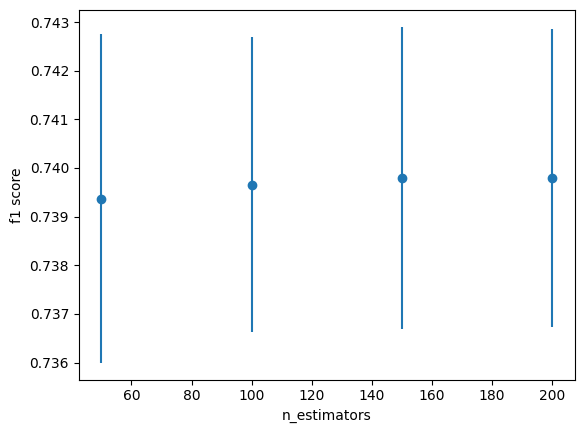

In [42]:
plot_score(grid_result_estimators, 'n_estimators')

best estimators = 150

In [43]:
xgbc = xgb.XGBClassifier(max_depth = 20, n_estimators =150)

In [44]:
params={
 "learning_rate"    : [0.1, 0.2, 0.3] ,
 "min_child_weight" : [ 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.05, 0.1, 0.2 , 0.3],
 "colsample_bylevel" :[0.2, 0.5, 0.8, 1.0],
 "colsample_bynode": [0.2, 0.5, 0.8, 1.0],
 "subsample": [0.2, 0.5, 0.8, 1.0],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    }

In [45]:
from sklearn.model_selection import RandomizedSearchCV 

rand_search = RandomizedSearchCV(xgbc, param_distributions = params, n_iter = 10 ,
                                scoring ='f1_micro', n_jobs=-1, verbose = 3)

In [46]:
rand_res = rand_search.fit(x, label_encoded_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5] END colsample_bylevel=0.2, colsample_bynode=0.8, colsample_bytree=0.4, gamma=0.05, learning_rate=0.1, min_child_weight=5, subsample=0.2;, score=0.690 total time=  23.2s
[CV 2/5] END colsample_bylevel=0.8, colsample_bynode=1.0, colsample_bytree=0.4, gamma=0.3, learning_rate=0.3, min_child_weight=3, subsample=0.2;, score=0.721 total time=  44.4s
[CV 1/5] END colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, min_child_weight=5, subsample=1.0;, score=0.743 total time=  34.3s
[CV 4/5] END colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, min_child_weight=5, subsample=1.0;, score=0.741 total time=  33.7s
[CV 3/5] END colsample_bylevel=1.0, colsample_bynode=0.8, colsample_bytree=0.3, gamma=0.3, learning_rate=0.3, min_child_weight=5, subsample=0.8;, score=0.746 total time=  30.4s
[CV 2/5] END colsample_bylevel=0.8, colsample_bynode=

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [47]:
best_params = rand_res.best_params_
print(best_params)

{'subsample': 0.8, 'min_child_weight': 5, 'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 0.3, 'colsample_bynode': 0.8, 'colsample_bylevel': 1.0}


In [48]:
best_params = {
    'subsample': 1.0,
    'min_child_weight': 3,
    'learning_rate': 0.1,
    'gamma': 0.1,
    'colsample_bytree': 0.4,
    'colsample_bynode': 0.8,
    'colsample_bylevel': 1.0
}

In [49]:
xgbc = xgb.XGBClassifier( min_child_weight = 3, learning_rate = 0.1, 
                        gamma = 0.1, subsample = 1.0 , colsample_bytree = 0.4,
                        colsample_bynode = 0.8, colsample_bylevel = 1.0, max_depth = 20,
                        n_estimators = 150)

In [50]:
xgbc.fit(x, label_encoded_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1.0, colsample_bynode=0.8, colsample_bytree=0.4,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [51]:
test = pd.read_csv('/kaggle/input/damage-prediction/test_values.csv')
submission_ids = test.pop('building_id')
transform_to_int(test, get_ob(test))

submission_prediction = xgbc.predict(test) + 1

In [52]:
submission = pd.DataFrame({'building_id': submission_ids, 'damage_grade': submission_prediction})


In [53]:
submission['damage_grade'].value_counts()

damage_grade
2    56191
3    24494
1     6183
Name: count, dtype: int64

In [54]:
submission.to_csv('kaggle_notebook_basics_2.csv', index = False)

After submission the file final score is 0.7466